# libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import datetime
from itertools import product
from collections import defaultdict
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Rectangle
import pandas as pd
import plotly.express as px
import seaborn as sns


import sys
sys.path.append('../..')
from src.model.theta import KNN
from src.model.simulation import monte_carlo
from src.model.true import check_duration
from src.validation.validation import loss

# Variaveis

In [2]:
def cossine(K, A, phi, f):
    x = list(range(1, 366))
    theta = [
        K + A*np.cos(2*np.pi*f*(i-phi)/365)
        for i in x]
    return theta

In [3]:
def decay(theta, A, years):
    next_years = 10
    values = [
        {
            'date': f"""{
                str(2000 + years + next_years - yi).zfill(4)
                }-{
                datetime.datetime.strptime(str(i+1), '%j').strftime('%m-%d')
                }""",
            'task': (t - A*(max(y, 0)/(years-1))),
            'dataset': ('test' if yi < next_years else 'training')
        }
        for yi, y in enumerate(range(-next_years, years))
        for i, t in enumerate(theta)
        ]
    return pd.DataFrame(values).sort_values('date', ascending=False)

In [4]:
sazonalities = {
    #'constant': np.array([0.5 for i in range(365)]),
    'cossine': np.array(cossine(0.7, 0.2, 240, 1)),
    '2_waves': np.array(cossine(0.8, 0.1, 1, 1))*np.array(cossine(0.8, 0.2, 1, 2)),
    '3_waves': np.array(cossine(.75, 0.25, 1, 2))*np.array(cossine(0.8, 0.2, 240, 1))
    }
experiments = [
    {'amplitude': 0, 'sazonality': 'cossine'},
    {'amplitude': 0.3, 'sazonality': 'cossine'},
    {'amplitude': 0, 'sazonality': '2_waves'},
    {'amplitude': 0, 'sazonality': '3_waves'}
]

In [5]:
hpt = []
for a in [0.6, 0.7, 0.8, 0.9, 1]:
    for w in [0, 3, 7]:    
        hpt.append({'window': w, 'alpha': a, 'fi': 'average_window', 'fy': 'exponencial'})
    hpt.append({'alpha': a, 'fi': 'cossine', 'fy': 'exponencial'})

In [6]:
project_schedule = {
    'task': 90
    }
B=100_000

# Gerando dados

In [7]:
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py

In [8]:
hpt = []
for alpha in [0.85, 0.9, 0.95, 1.]:
    for smoothing in [0, 3, 7]:
        if smoothing  == 0:
            cossines = [True, False]
        else:
            cossines = [False]
        for cossine in cossines:
            hpt.append({'alpha': alpha, 'smoothing': smoothing, 'mc': False, 'cossine': cossine})
hpt

[{'alpha': 0.85, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 0.85, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 0.85, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 0.85, 'smoothing': 7, 'mc': False, 'cossine': False},
 {'alpha': 0.9, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 0.9, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 0.9, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 0.9, 'smoothing': 7, 'mc': False, 'cossine': False},
 {'alpha': 0.95, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 0.95, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 0.95, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 0.95, 'smoothing': 7, 'mc': False, 'cossine': False},
 {'alpha': 1.0, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 1.0, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 1.0, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 1.0, 'smoothing': 7, 'mc'

In [9]:
from src.model.weather_pert import WeatherPert

In [10]:
experimentos = [
    f"Experimento 1", f"Experimento 2",
    f"Experimento 3", f"Experimento 4"]
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, shared_yaxes=True,
    subplot_titles= experimentos)
colors = {
    'training': '#1F78B4',
    'test': '#FE7F0E'
}
for i, experiment in enumerate(experiments):
    row = i + 1
    amplitude = experiment['amplitude']
    sazonality = experiment['sazonality']
    theta = sazonalities[experiment['sazonality']]
    data = decay(theta, A=amplitude, years=30)
    n_training = (data['dataset'] == 'training').sum()
    data['Ano'] = [((len(data) - i) - n_training)/365 for i in range(len(data))]
    data = data[data['Ano'].between(-10, 1)]
    for dataset in ['training', 'test']:
        data_dataset = data.loc[lambda df: df['dataset'] == dataset]

        fig_ = go.Scatter(
            x=data_dataset['Ano'], y=data_dataset['task'],
            mode='lines+markers',
            name='Treino' if dataset == 'training' else 'Teste',
            line=dict(color=colors[dataset], width=2),
            marker=dict(color=colors[dataset], size=1),
            )
        if i > 0:
            fig_.update(showlegend=False)
        fig.add_trace(fig_, row=row, col=1)

fig.update_xaxes(tickvals=[-15, -10, -5, 0],ticktext=[-15, -10, -5, 0], row=4, col=1)
fig.update_yaxes(title_text='Probabilidade', range=[0,1], row=1, col=1)
fig.update_yaxes(title_text='Probabilidade', range=[0,1], row=2, col=1)
fig.update_yaxes(title_text='Probabilidade', range=[0,1], row=3, col=1)
fig.update_yaxes(title_text='Probabilidade', range=[0,1], row=4, col=1)

fig.update_xaxes(title_text='Ano', row=4, col=1)
fig.update_layout(
    template = "simple_white",
    width=600, height=900,
    )
fig#.write_image("simulado_probabilidades.pdf")

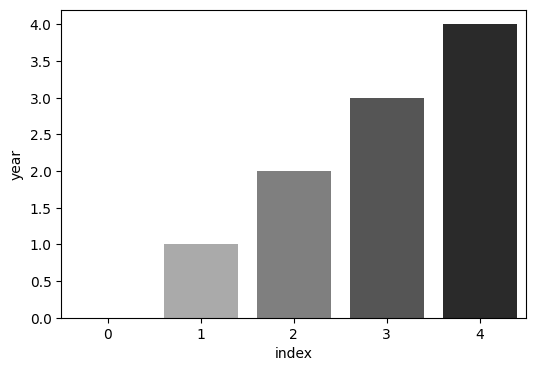

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns

df=pd.DataFrame(data=[i for i in range(5)],columns=['year'])
table=df['year'].reset_index()
fig, ax1 = plt.subplots(figsize=(6,4))
sns.barplot(x='index', y='year', data=table, ax=ax1, palette='gist_gray_r')

bars = [r for r in ax1.get_children() if type(r)==Rectangle]
colors = [c.get_facecolor() for c in bars[:-1]]
colors = [f"rgb({c[0]},{c[1]},{c[2]})" for c in colors]

In [12]:
all_result = {}
result = pd.DataFrame()
comb = len(experiments)
selected_params = pd.DataFrame()
plot_data_values = pd.DataFrame()

for exp_i, experiment in enumerate(experiments):
    amplitude = experiment['amplitude']
    sazonality = experiment['sazonality']
    theta = sazonalities[experiment['sazonality']]
    #data = decay(theta, A=amplitude, years=30)
    
    hpt_result = []
    for date in [
            '2031-01-01', '2031-02-01', '2031-03-01', '2031-04-01',
            '2031-05-01', '2031-06-01', '2031-07-01', '2031-08-01',
            '2031-09-01', '2031-10-01', '2031-11-01', '2031-12-01',
            ]:
        data = decay(theta, A=amplitude, years=30)
        data['dataset'] = data['date'].apply(lambda v: 'test' if  v >= date else 'training')
        data['task'] = data.apply(lambda row: (
            (random.random() <= row['task'])*1 
            if row['dataset']=='training' 
            else row['task']
            ), axis=1)
        
        if date == '2031-01-01':
            plot_data_values = pd.concat([plot_data_values, data.assign(Experiment = f"Experiment {exp_i+1}")])
        training, test = [
            data.loc[lambda df: df.dataset == ds, ['date', 'task']]
            for ds in ['training', 'test']]
        plot_crc_values = pd.DataFrame()
        observed = check_duration(data=test, date_start=date, project_schedule=project_schedule)
        print('observed ', observed)
        for j, hp in enumerate(hpt):
            start = time.time()
            model = WeatherPert(**hp, column_date='date')
            model.fit(data=training[['date', 'task']])
            crc_knn = model.theta
            param_name = f"alpha={hp['alpha']} | smoothing={hp['smoothing']} | cossine={hp['cossine']}"
            plot_crc_values = pd.concat([plot_crc_values,(
                pd.DataFrame({'theta': crc_knn['task'], 'i': list(range(365))})
                .assign(Parameter = param_name)
                )])
            durations = model.predict(date_start=date, project_schedule=project_schedule)
            
            _loss = loss(observed=observed, estimate=durations, loss_type = 'right-tail')
            hpt_result.append({
                'date': date,
                'sazonality': sazonality,
                'amplitude': amplitude,
                #'mse': fitted.get('mse'),
                #'K': fitted.get('K'),
                #'A': fitted.get('A'),
                #'phi': fitted.get('phi'),
                'alpha': hp['alpha'],
                'smoothing': hp['smoothing'],
                'cossine': hp['cossine'],
                'right-tail': _loss,
                })
            print(f"""{
                str(exp_i).zfill(len(str(comb)))}/{comb
                } |  date={date} | {
                str(j).zfill(len(str(len(hpt))))}/{len(hpt)
                } | {
                round(time.time()-start, 3)
                } s    """, end='\r')
        df_plot = (
            plot_crc_values
            .rename(columns={'i': 'day of year'})
            .assign(
                alpha = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[0]),
                smoothing = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[1]),
                cossine = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[2])
                )
            .sort_values(['alpha', 'smoothing', 'cossine', 'day of year'])
        )

        graphs = [
            ('smoothing=0', 'cossine=False'),
            ('smoothing=0', 'cossine=True'),
            ('smoothing=3', 'cossine=False'),
            ('smoothing=7', 'cossine=False'),
        ]
        numerate = ['(a)', '(b)', '(c)', '(d)']
        if date == '2031-01-01':
            fig = make_subplots(
                rows=2, cols=2, shared_xaxes=True, shared_yaxes=True,
                subplot_titles= [(
                    f"{numerate[i]} {graph[0]} | {graph[1]}"
                    ) for i, graph in enumerate(graphs)],
                horizontal_spacing = 0.1,
                vertical_spacing  = 0.1
                )

            axis = {0: (1, 1), 1: (1, 2), 2: (2, 1), 3: (2, 2)}
            for j, graph in enumerate(graphs):
                smoothing = graph[0]
                cossine = graph[1]
                x_i, y_i = axis[j]
                df_plot_i = (
                    df_plot
                    .loc[lambda df: (df.smoothing==smoothing)&(df.cossine==cossine)]
                    .sort_values('day of year')
                    )
                
                for i, a in enumerate([0.85, 0.9, 0.95, 1.0]):
                    x = df_plot_i.loc[lambda df: df.alpha == f'alpha={a}', 'day of year'].tolist()
                    y = df_plot_i.loc[lambda df: df.alpha == f'alpha={a}', 'theta'].tolist()
                    fig_ = go.Scatter(
                        x=x, y=y,
                        mode='lines',
                        name=a,
                        line=dict(color=colors[i], width=2)
                        )
                    if j > 0:
                        fig_.update(showlegend=False)
                    fig.add_trace(fig_, row=x_i, col=y_i)
            fig.update_layout(
                template = "simple_white",
                width=800, height=500,
                margin=dict(t=50)
                )
            fig.update_layout(legend_title_text='alpha')
            fig.update_xaxes(title_text='$i$', row=2, col=1)
            fig.update_xaxes(title_text='$i$', row=2, col=2)
            fig.update_yaxes(title_text='$\widehat \\theta_{t,i}$', row=1, col=1)
            fig.update_yaxes(title_text='$\widehat \\theta_{t,i}$', row=2, col=1)
            fig.update_layout(legend=dict(orientation='v', yanchor='bottom', y=0.8))#))
            fig.write_image(f'simulado_theta_{exp_i+1}.pdf')
    hpt_result = pd.DataFrame(hpt_result).assign(Experimento = f"Experimento {exp_i+1}")
    result = pd.concat([result, hpt_result])

observed  159


observed  150031-01-01 | 15/16 | 0.271 s    
observed  139031-02-01 | 15/16 | 0.271 s    
observed  127031-03-01 | 15/16 | 0.26 s     
observed  116031-04-01 | 15/16 | 0.27 s     
observed  107031-05-01 | 15/16 | 0.237 s    
observed  104031-06-01 | 15/16 | 0.234 s    
observed  105031-07-01 | 15/16 | 0.225 s    
observed  115031-08-01 | 15/16 | 0.227 s    
observed  134031-09-01 | 15/16 | 0.24 s     
observed  153031-10-01 | 15/16 | 0.257 s    
observed  161031-11-01 | 15/16 | 0.274 s    
observed  159031-12-01 | 15/16 | 0.276 s    
observed  150031-01-01 | 15/16 | 0.302 s    
observed  139031-02-01 | 15/16 | 0.291 s    
observed  127031-03-01 | 15/16 | 0.284 s    
observed  116031-04-01 | 15/16 | 0.272 s    
observed  107031-05-01 | 15/16 | 0.257 s    
observed  104031-06-01 | 15/16 | 0.251 s    
observed  105031-07-01 | 15/16 | 0.245 s    
observed  115031-08-01 | 15/16 | 0.314 s    
observed  134031-09-01 | 15/16 | 0.374 s    
observed  153031-10-01 | 15/16 | 0.297 s    
observed  

In [13]:
result.to_csv('result.csv', index=False)

In [14]:
all_result = pd.read_csv('result.csv')

In [15]:
summary_result = (
    all_result
    .groupby(['Experimento', 'alpha', 'smoothing', 'cossine'])
    .agg(
        right_tail=('right-tail', 'mean'),
        right_tail_std=('right-tail', np.std),
        count=('right-tail', 'count'),
        )
    .reset_index()
    .sort_values(['Experimento','right_tail'])
    .assign(right_tail_error = lambda df: df['right_tail_std']/np.sqrt(df['count']))
)
summary_result

,Experimento,alpha,smoothing,cossine,right_tail,right_tail_std,count,right_tail_error
4,Experimento 1,0.90,0,False,0.238914,0.084196,12,0.024305
8,Experimento 1,0.95,0,False,0.240061,0.087098,12,0.025143
15,Experimento 1,1.00,7,False,0.243605,0.094767,12,0.027357
12,Experimento 1,1.00,0,False,0.244311,0.091629,12,0.026451
10,Experimento 1,0.95,3,False,0.245551,0.093385,12,0.026958
...,...,...,...,...,...,...,...,...
51,Experimento 4,0.85,7,False,0.366464,0.167295,12,0.048294
61,Experimento 4,1.00,0,True,0.737600,0.397142,12,0.114645
57,Experimento 4,0.95,0,True,0.749929,0.418126,12,0.120703
49,Experimento 4,0.85,0,True,0.753781,0.451956,12,0.130468


In [16]:
summary_result['Experimento'].value_counts()

Experimento
Experimento 1    16
Experimento 2    16
Experimento 3    16
Experimento 4    16
Name: count, dtype: int64

In [18]:
#result["Experimento"] = [f"Experimento {e}" for e in range(1, 5) for i in range(len(hpt))]
summary_result["theta"] = summary_result.apply(lambda row: f"smoothing={row['smoothing']} | cossine={row['cossine']}", axis=1).astype(str)
summary_result['theta_name'] = summary_result["theta"]
sort_xaxis = [
    "smoothing=0 | cossine=True",
    "smoothing=0 | cossine=False",
    "smoothing=3 | cossine=False",
    "smoothing=7 | cossine=False"]

fig.update_xaxes(tickvals=[0, 1, 2],
                 ticktext=["smoothing=3<br>cossine=True",
                           "outro valor",
                           "mais um valor"])
experimentos = [
    f"Experimento 1", f"Experimento 2",
    f"Experimento 3", f"Experimento 4"]
fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=False,
    subplot_titles= [
        f"Experimento 1", f"Experimento 2",
        f"Experimento 3", f"Experimento 4"],
        horizontal_spacing = 0.1,
        vertical_spacing  = 0.1
    )

axis = {0: (1, 1), 1: (1, 2), 2: (2, 1), 3: (2, 2)}
for j, exp in enumerate(experimentos):
    x_i, y_i = axis[j]
    df_plot_i = (
        summary_result
        .loc[lambda df: df.Experimento==exp]
        .assign(sort_xaxis = lambda df: df['theta_name'].apply(lambda x: sort_xaxis.index(x)))
        .sort_values(['sort_xaxis', 'alpha'])
        )
    for i, a in enumerate([0.85, 0.9, .95,  1]):
        x = df_plot_i.loc[lambda df: df.alpha == a, 'theta_name'].tolist()
        y = df_plot_i.loc[lambda df: df.alpha == a, 'right_tail'].tolist()
        fig_ = go.Scatter(
            x=x, y=y,
            mode='markers',
            name=f'{a}',
            line=dict(color=colors[i], width=2)
            )
        if j > 0:
            fig_.update(showlegend=False)
        fig.add_trace(fig_, row=x_i, col=y_i)
        fig.update_yaxes(range=[0, df_plot_i['right_tail'].max()], row=x_i, col=y_i)
fig.update_layout(
    template = "simple_white",
    width=1100, height=700,
    margin=dict(t=50)
    )
ticktext = [
 'smoothing=0        <br>  cossine=True ',
 'smoothing=0        <br>  cossine=False',
 'smoothing=3        <br>  cossine=False',
 'smoothing=7        <br>  cossine=False']
fig.update_layout(legend_title_text='alpha')
fig.update_xaxes(tickvals=[0, 1, 2, 3],ticktext=ticktext, row=2, col=1)
fig.update_xaxes(tickvals=[0, 1, 2, 3],ticktext=ticktext, row=2, col=2)
fig.update_yaxes(title_text='Perda', row=1, col=1)
fig.update_yaxes(title_text='Perda', row=2, col=1)
fig.write_image('simulado_resultados.pdf')

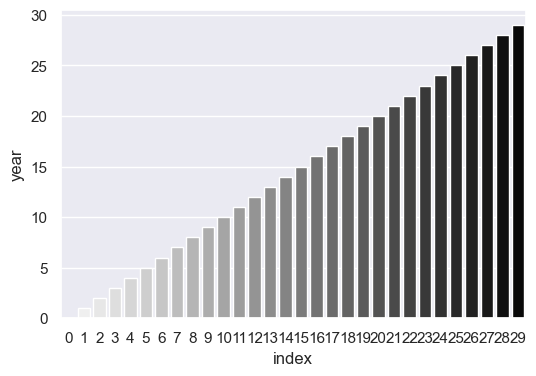

In [20]:
%matplotlib inline
sns.set()

df=pd.DataFrame(data=[i for i in range(30)],columns=['year'])
table=df['year'].reset_index()
fig, ax1 = plt.subplots(figsize=(6,4))
sns.barplot(x='index', y='year', data=table, ax=ax1, palette='gist_gray_r')

bars = [r for r in ax1.get_children() if type(r)==Rectangle]
gray_colors = [c.get_facecolor() for c in bars[:-1]]
gray_colors = [f"rgb({c[0]},{c[1]},{c[2]})" for c in gray_colors]
gray_colors.sort()

In [21]:
fig = (
    plot_data_values
    .assign(
        year = lambda df: df.date.apply(lambda v: ((int(v[:4]))-2000)),
        month = lambda df: df.date.apply(lambda v: int(v[5:7]))
        )
    .assign(year = lambda df: np.where(df.year <= 30, df.year-31, df.year-30))
    .loc[lambda df: df.year <= 0]
    .groupby(['year', 'month', 'dataset', 'Experiment'])
    .agg(task=('task', 'mean'))
    .reset_index()
    .sort_values(['year', 'month'], ascending=False)
    .rename(columns={
        'task': 'Dias trabalhados (%)',
        'year': 'Ano',
        'month': 'Mês',
        'Experiment': 'Experimento'
    })
    .assign(Experimento = lambda df: df['Experimento'].apply(lambda v: v.replace('Experiment', 'Experimento')))
    .pipe(lambda df: (
        px.line(
            df, x='Mês', y='Dias trabalhados (%)', color='Ano',
            template="simple_white",
            color_discrete_sequence=gray_colors,
            facet_col='Experimento', facet_col_wrap=1)
    ))
)
fig.update_layout(
    yaxis_range=[0,1],
    width=600, height=900,
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig.write_image('simulado_dados.pdf')
#plot_url = py.plot(fig, filename='latex', include_mathjax='cdn')

In [71]:
sazonalities.keys()
rename = {
    'cossine': 'Experimento 1 e 2',
    '2_waves': 'Experimento 3',
    '3_waves': 'Experimento 4'
    }
plot_data = pd.DataFrame()
for name, theta in sazonalities.items():
    experiment = rename[name]
    plot_data = pd.concat([plot_data, (
        pd.DataFrame({'p': theta})
        .assign(
            experiment = experiment,
            i = list(range(365))
            )
        .rename(columns = {'i': 'day of year'})
        )])
fig = px.line(
    plot_data, x='day of year', y='p', color='experiment',
    template="simple_white")
fig.update_layout(
    yaxis_range=[0,1],
    #width=600, height=400,
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig.update_layout(legend_title_text='Experimento')
fig.update_xaxes(title_text='Dia do ano')
fig.update_yaxes(title_text='Probabilidade')
plot_url = py.plot(fig, filename='latex', include_mathjax='cdn')